In [1]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
import os # reading the input files we have access to

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import warnings

import chainer
import chainer.functions as F
import chainer.links as L
import math
from chainer import cuda, training, reporter, Variable
from chainer.training import trainer, extensions
from chainer import datasets
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module
from chainer import optimizer as optimizer_module
from chainer import iterators
from chainer import optimizers

warnings.filterwarnings('ignore')
%matplotlib inline

device = 0

print(os.listdir('./input'))


['GCP-Coupons-Instructions.rtf', 'train.csv.zip', 'sample_submission.csv', 'test.csv', 'train.csv']


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_df =  pd.read_csv('./input/train.csv', nrows = 10_000_000)
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [3]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df.pickup_datetime = pd.to_datetime(df.pickup_datetime).dt.timestamp()

add_travel_vector_features(train_df)

In [4]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


In [5]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


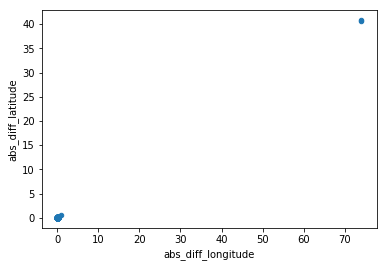

In [6]:
%matplotlib inline
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [7]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


In [8]:
print(train_df.shape)

(9979187, 10)


In [9]:
def get_input_matrix(df):
    #df.pickup_datetime = int(pd.to_datetime(df.pickup_datetime).dt.strftime('%Y%m%d%H%M'))
    
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, df.passenger_count)).astype(np.float32)

def get_output_matrix(df):
    return np.column_stack((df.fare_amount)).astype(np.float32).transpose((1, 0))

train_x = get_input_matrix(train_df)
train_t = get_output_matrix(train_df)

test_df = pd.read_csv('./input/test.csv')
add_travel_vector_features(test_df)
test_x = get_input_matrix(test_df)
#print(train_x.shape, train_t.shape, test_x.shape)
thresh_hold = int(train_x.shape[0]*0.8)
train = datasets.TupleDataset(train_x[:thresh_hold], train_t[:thresh_hold])
valid = datasets.TupleDataset(train_x[thresh_hold:], train_t[thresh_hold:])

In [10]:
print(train_x.shape, train_t.shape, test_x.shape)

(9979187, 3) (9979187, 1) (9914, 3)


In [11]:
class LinearBlock(chainer.Chain):

    def __init__(self, inp=None, mid=256, drop=False, bn = False):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(inp, mid, initialW=w)
            self.bnorm = L.BatchNormalization(mid)
        self.drop = drop
        self.bn = bn

    def __call__(self, x):
        h = self.fc(x)
        if self.bn:
            h = self.bnorm(h)
        h = F.relu(h)
        if self.drop:
            h = F.dropout(h)
        return h
    
class EnsembleNet(chainer.Chain):
    def __init__(self, mid):
        super(EnsembleNet, self).__init__()
        w = chainer.initializers.HeNormal()
        
        with self.init_scope():
            self.l1 = LinearBlock(mid = mid, bn = True)
            self.l2 = LinearBlock(mid = mid*2, bn = True)
            
            self.last = L.Linear(None, 1, initialW=w)
            
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        h = self.last(self.l2(self.l1(x)))
        #h = F.concat((h1, h2, h3, h4), axis = -1)
        #h = h1
        #h = F.mean(h, axis=-1, keepdims=True)
        #h  = self.concat(F.relu(h))
        return h
    
#     def predict(self, x):
#         with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
#             y_pred = F.mean(self.forward(x), axis=-1, keepdims=True)
#         return y_pred
            

In [12]:
import chainer
import numpy as np
import six
import chainer.functions as F
import chainer.links as L
from chainer import training, cuda, reporter
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module

class EnsembleUpdater(training.StandardUpdater):
    def __init__(self, iterator, net_dict, opt,
        converter=convert.concat_examples, device=0):
        if isinstance(iterator, iterator_module.Iterator):
            iterator = {'main': iterator}
        self._iterators = iterator
        self.net_dict = net_dict
        self._optimizers = opt
        self.converter = converter
        self.device = device
        self.iteration = 0

    def update_core(self):
        #print(self.iteration)
        iterator = self._iterators['main'].next()
        #入力データ
        input = self.converter(iterator, self.device)
        xp = np if int(self.device) == -1 else cuda.cupy
        x_batch = xp.array(input[0], dtype=np.float32) #入力データ
        t_batch = xp.array(input[1], dtype=np.float32) #教師データ
        #loss
        loss_dic = {}
        for i, net in enumerate(self.net_dict.values()):
            loss = F.mean_squared_error(net(x_batch), t_batch)
            loss_dic[str(i)] = loss
            
        #計算開始
        for name, optimizer in six.iteritems(self._optimizers):
            optimizer.target.cleargrads()
            
        for name, loss in six.iteritems(loss_dic):
            loss.backward()

        for name, optimizer in six.iteritems(self._optimizers):
            optimizer.update()
        report_dict = {}
        for i, loss in enumerate(loss_dic.values()):
            report_dict['main/loss'+str(i)] =  loss
        reporter.report(report_dict)

        
import chainer
import copy
import numpy as np
import chainer.functions as F
import chainer.links as L
from chainer import training, cuda, reporter
from chainer.training import extensions
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module

class  EnsembleEvaluator(extensions.Evaluator):
    def __init__(self, iterator, net_dict,
        converter=convert.concat_examples, device=0, eval_hook=None,
        eval_func=None):
        if isinstance(iterator, iterator_module.Iterator):
            iterator = {'main': iterator}
        self._iterators = iterator
        self._targets = net_dict
        self.converter = converter
        self.device = device
        self.eval_hook = eval_hook

    def evaluate(self):
        iterator = self._iterators['main']
        #入力データ
        xp = np if int(self.device) == -1 else cuda.cupy
        it = copy.copy(iterator)
        summary = reporter.DictSummary()
        for batch in it:
            observation = {}
            with reporter.report_scope(observation):
                input = self.converter(batch, self.device)
                x_batch = xp.array(input[0], dtype=np.float32) #入力データ
                t_batch = xp.array(input[1], dtype=np.float32) #教師データ
                #loss
                loss = 0
                #計算開始
                with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                    for i, net in enumerate(self._targets.values()):
                        loss = loss + F.mean_squared_error(net(x_batch), t_batch)
                    loss = loss/len(self._targets.values())
                observation['val/main/loss'] = loss
            summary.add(observation)
        return summary.compute_mean()

In [13]:
batch_size = 64
train_iter = iterators.SerialIterator(train, batch_size)
valid_iter  = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test_x, batch_size, False, False)

In [14]:
net1 = EnsembleNet(mid = 8)
net2 = EnsembleNet(mid = 16)
net3 = EnsembleNet(mid = 32)
net4 = EnsembleNet(mid = 64)
net_dict = {'0': net1, '1': net2, '2': net3, '3': net4}
optimizer_dict= {}
for i, net in enumerate(net_dict.values()):
        if device >= 0:
            net.to_gpu(device)
        optimizer = optimizers.Adam(alpha=0.0002, beta1=0.9, beta2=0.999).setup(net)
        optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))
        optimizer_dict[str(i)] = optimizer

In [15]:
updater = EnsembleUpdater(train_iter, net_dict, optimizer_dict, device=device)
max_iteration = 10000
trainer = training.Trainer(updater, (max_iteration, 'iteration'), out='results')
trainer.extend(extensions.LogReport(trigger=(100, 'iteration')))
print_report_list = []
for i, net in enumerate(net_dict.values()):
    trainer.extend(extensions.snapshot_object(net, filename='net'+str(i)+'_iteration-{.updater.iteration}'), trigger=(1000,'iteration'))
    print_report_list.append('main/loss'+str(i))
trainer.extend(EnsembleEvaluator(valid_iter, net_dict, device=device), name='val', trigger=(100,'iteration'))
trainer.extend(extensions.PrintReport(['iteration', print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3],  'val/main/loss', 'elapsed_time']))
trainer.extend(extensions.PlotReport([print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3], 'val/main/loss'], x_key='iteration', file_name='loss.png'))
#trainer.extend(extensions.dump_graph(print_report_list[0], print_report_list[1], print_report_list[2], print_report_list[3],))

In [ ]:
trainer.run()

In [17]:
infer_net1 = EnsembleNet(mid = 8)
infer_net2 = EnsembleNet(mid = 16)
infer_net3 = EnsembleNet(mid = 32)
infer_net4 = EnsembleNet(mid = 64)
infer_net_dict = {'0': net1, '1': net2, '2': net3, '3': net4}
from chainer import serializers
for i, infer_net in enumerate(infer_net_dict.values()):
    serializers.load_npz('results/'+'net'+str(i)+'_iteration-10000', infer_net, path='')
    if device >= 0:
        infer_net.to_gpu(0)

In [18]:
t_x = test_x
t_x = infer_net.xp.asarray(t_x)
y_pred = 0
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for i, infer_net in enumerate(infer_net_dict.values()):
        y_pred = y_pred + infer_net(t_x).array
    y = y_pred / len(infer_net_dict.values())

In [19]:
y_pred = chainer.cuda.to_cpu(y)

In [24]:
y_pred = y_pred.reshape(-1)
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': y_pred},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)